Import of library

In [1]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense,Dropout, LSTM
style.use('ggplot')
data_to_load = files.upload()

Saving Equities.csv to Equities.csv
Saving Positions.csv to Positions.csv
Saving Prices_2020.csv to Prices_2020.csv
Saving Prices_Jan_2021.csv to Prices_Jan_2021.csv


In [2]:
# store csv files 
import datetime as dt
equities = pd.read_csv('Equities.csv',sep='|',index_col='Ticker')
positions = pd.read_csv('Positions.csv',sep='|',index_col='Ticker')
prices_2020 = pd.read_csv('Prices_2020.csv',sep='|',index_col='Ticker')
prices_jan_2021 = pd.read_csv('Prices_Jan_2021.csv',sep='|',index_col='Ticker')

In [3]:
#convert column BuyDate to datetime
positions['BuyDate'] = pd.to_datetime(positions['BuyDate'], format='%Y%m%d')

In [4]:
from functools import reduce
dfs = [positions,equities,prices_jan_2021]
df_final = reduce(lambda left,right: pd.merge(left,right,on='Ticker'),dfs)

In [5]:
df_final['BuyDate'] = pd.to_datetime(df_final['BuyDate'], format='%Y-%m-%d')

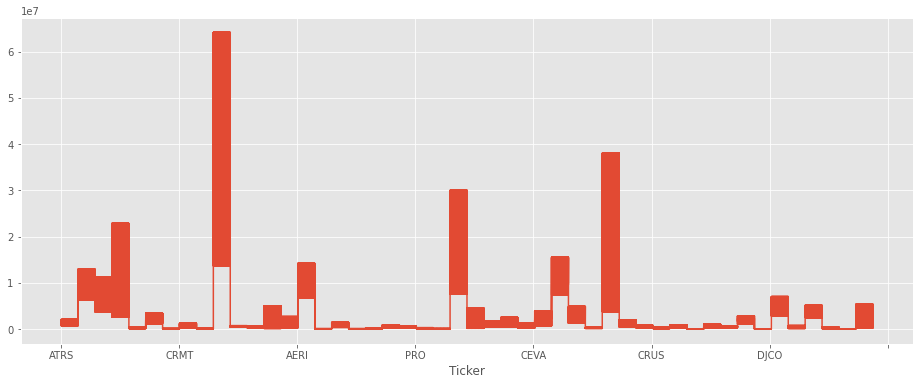

In [6]:
df_final.set_index('BuyDate')
df_final['Volume'].plot(figsize=(16,6))

In [7]:
#clean nan values
prices_2020 = prices_2020.dropna()


In [8]:
df_filter_prices_sell = prices_2020.where(prices_2020['Date'] =='2020-01-02')


In [9]:
sell_price = df_filter_prices_sell['Price'][0]

In [10]:
df_filter_prices_buy = prices_2020.where(prices_2020['Date'] =='2020-12-31')

In [11]:
buy_price = df_filter_prices_buy['Price'][len(df_filter_prices_buy) -1]

In [12]:
df_final['pnl'] = (sell_price - buy_price)* df_final['Quantity']

In [13]:
df_final

,Strategy,Book,BuyDate,Quantity,Currency,Country,Industry,Date,Price,Volume,pnl
Ticker,,,,,,,,,,,
ATRS,S0,S0B0,2020-01-02,56,USD,UNITED STATES,Pharmaceuticals,2021-01-04,3.890,1181537,3063.76
ATRS,S0,S0B0,2020-01-02,56,USD,UNITED STATES,Pharmaceuticals,2021-01-05,3.815,1273463,3063.76
ATRS,S0,S0B0,2020-01-02,56,USD,UNITED STATES,Pharmaceuticals,2021-01-06,3.850,1276509,3063.76
ATRS,S0,S0B0,2020-01-02,56,USD,UNITED STATES,Pharmaceuticals,2021-01-07,3.950,714509,3063.76
ATRS,S0,S0B0,2020-01-02,56,USD,UNITED STATES,Pharmaceuticals,2021-01-08,3.980,1851004,3063.76
...,...,...,...,...,...,...,...,...,...,...,...
AXAS,S31,S31B411,2020-01-02,90,USD,UNITED STATES,Oil&Gas,2021-01-22,2.690,209766,4923.90
AXAS,S31,S31B411,2020-01-02,90,USD,UNITED STATES,Oil&Gas,2021-01-25,2.680,430483,4923.90
AXAS,S31,S31B411,2020-01-02,90,USD,UNITED STATES,Oil&Gas,2021-01-26,2.650,578646,4923.90


In [14]:
pnl_query = df_final.groupby(['Strategy','Ticker','Currency','Country','Industry','BuyDate'])['pnl'].sum().reset_index()

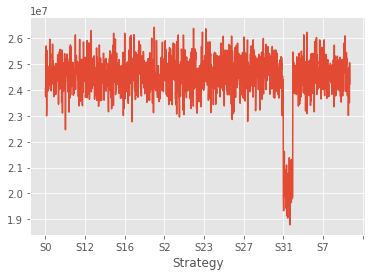

In [15]:
pnl_query['BuyDate'] = pd.to_datetime(pnl_query['BuyDate'], format='%Y-%m-%d')
pnl_query = pnl_query.set_index('Strategy')
pnl_query['pnl'].plot()

In [17]:
#clean nan values
prices_2020 = prices_2020.dropna()
prices_jan_2021 = prices_jan_2021.dropna()

In [18]:
#parse the column Date to datetime
total_prices = pd.concat((prices_2020,prices_jan_2021),axis=0)
total_prices['Date'] = pd.to_datetime(total_prices['Date'], format='%Y-%m-%d')


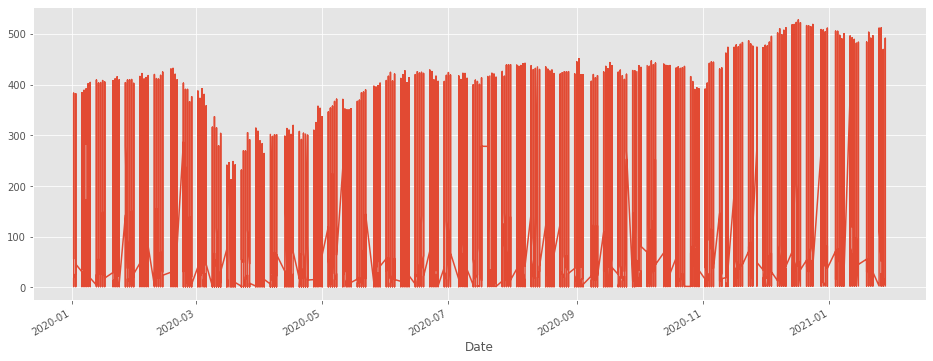

In [21]:
# overview 
total_prices = total_prices.set_index('Date')
total_prices['Price'].plot(figsize=(16,6))

In [22]:
#prepare the data
scaler = MinMaxScaler(feature_range=(0,1))
scale_data = scaler.fit_transform(prices_2020['Price'].values.reshape(-1,1))
predictions_days  = 30 
x_train = []
y_train = []

for x in range(predictions_days,len(scale_data)):
  x_train.append(scale_data[x-predictions_days:x, 0])
  y_train.append(scale_data[x,0])

x_train,y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1 ))

In [29]:
#build model
#initializing the RNN
model = Sequential()

#adding the first LSTM layer and some Dropout for regularization
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

#adding the second LSTM layer and some Dropout for regularization
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

#adding the Third LSTM layer and some Dropout for regularization
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

#adding a fourth LSTM Layer and some Dropout for regularization
model.add(LSTM(units=50))
model.add(Dropout(0.2))

#adding the output layer
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train,y_train, epochs=25, batch_size=32)
test_data = prices_jan_2021
actual_prices = test_data['Price'].values
total_prices = pd.concat((prices_2020['Price'],prices_jan_2021['Price']),axis=0)
model_inputs = total_prices[len(total_prices) - len(test_data) - predictions_days: ].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

#Make predictions on test
x_test = []
for x in range(predictions_days,len(model_inputs)):
  x_test.append(model_inputs[x-predictions_days:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1], 1))

Epoch 1/25
391/391 [==============================] - 29s 59ms/step - loss: 0.0045
Epoch 2/25
391/391 [==============================] - 24s 61ms/step - loss: 0.0016
Epoch 3/25
391/391 [==============================] - 24s 61ms/step - loss: 0.0013
Epoch 4/25
391/391 [==============================] - 24s 61ms/step - loss: 0.0011
Epoch 5/25
391/391 [==============================] - 24s 62ms/step - loss: 9.4980e-04
Epoch 6/25
391/391 [==============================] - 24s 62ms/step - loss: 0.0010
Epoch 7/25
391/391 [==============================] - 24s 63ms/step - loss: 9.0781e-04
Epoch 8/25
391/391 [==============================] - 24s 62ms/step - loss: 7.1732e-04
Epoch 9/25
391/391 [==============================] - 24s 62ms/step - loss: 5.7811e-04
Epoch 10/25
391/391 [==============================] - 25s 63ms/step - loss: 6.2631e-04
Epoch 11/25
391/391 [==============================] - 25s 63ms/step - loss: 6.3090e-04
Epoch 12/25
391/391 [==============================] - 24s 63

In [30]:
predicted_prices = model.predict(x_test)

In [31]:
predicted = predicted_prices.reshape(-1,1)

In [32]:
final_predictions = scaler.inverse_transform(predicted)

In [33]:
predictions_prices = pd.DataFrame(final_predictions)

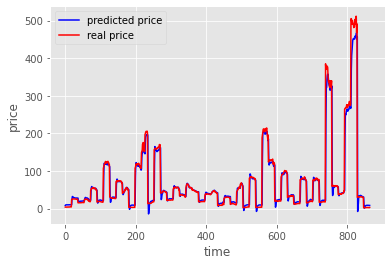

In [34]:
#plot the predicted prices and actuals prices
plt.plot(predictions_prices,color='blue',label='predicted price')
plt.plot(actual_prices,color='red',label='real price')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.show()

In [35]:
#fonction to optimize prices and pick up the best strategy
def max_profit(prices):
    if not prices:
        return 0

    max_prof = 0
    min_price = prices[0]

    for i in range(1, len(prices)):
        if prices[i] < min_price:
            min_price = prices[i]
        max_prof = max(max_prof, prices[i] - min_price)
    return max_prof